In [7]:
# import required modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from infrasim.component import Component
import pandas as pd
import numpy as np

In [8]:
# load component data
gen_admin_params = pd.read_csv('selected_15_components_data.csv')

component_ids = list(gen_admin_params['component_id'])
dynamics_shapes = list(gen_admin_params['shape'])
dynamics_scales = list(gen_admin_params['scale'])
inspection_costs = list(gen_admin_params['inspection_cost'])
replacement_costs = list(gen_admin_params['replacement_cost'])

In [9]:
def run_simulations(component, budget, num_trials, inspect_interval, replace_failure_threshold, visualize=False):

    # run a policy on the component with baseline strategy
    inspect_interval = inspect_interval
    replace_failure_threshold = replace_failure_threshold
    survive_probs = []

    for trial in range(num_trials):
        budget_remaining = budget
        component.reset()
        num_steps = 0
        last_known_state = 101
        num_survive_steps = 0

        while budget_remaining > 0 and num_steps < 100:

            if component.current_state > 0:
                num_survive_steps += 1

            # actions for baseline
            if num_steps % inspect_interval == 0:
                component.update(action=1)
                budget_remaining -= component.inspect_cost
                last_known_state = component.current_state
            elif component.get_failure_probability(last_known_state) >= replace_failure_threshold and budget_remaining >= component.replace_cost:
                component.update(action=2)
                budget_remaining -= component.replace_cost
                last_known_state = component.current_state
            else:
                component.update(action=0)
            num_steps += 1
        
        if visualize == True:
            component.visualize_history()
            print(f"Remaining budget: {budget_remaining}")
        survive_probs.append(num_survive_steps/100.0)

    return np.mean(survive_probs), np.std(survive_probs)

In [10]:
# run simulations with components

survival_means = np.zeros((len(component_ids),51))
survival_stds = np.zeros((len(component_ids),51))
budgets = np.arange(0,1001,20)
inspect_interval = 3
num_trials = 5
replace_failure_threshold = 0.5

for i in range(len(component_ids)):

    component =  Component(name=f'{component_ids[i]}', inspect_cost=inspection_costs[i], replace_cost=replacement_costs[i], dynamics_scale=dynamics_scales[i], dynamics_shape=dynamics_shapes[i])

    # load dynamics npy file
    trans_prob_maintain = np.load(f'./dynamics/dynamics_{component_ids[i]}.npy')
    component.trans_prob[:,2,:] = trans_prob_maintain[:,0,:]
    
    for j in range(len(budgets)):
        
        probs_mean, probs_std =  run_simulations(component, budgets[j], num_trials=num_trials, inspect_interval=inspect_interval, replace_failure_threshold=replace_failure_threshold)
        survival_means[i,j] = probs_mean
        survival_stds[i,j] = probs_std


In [11]:
np.save('./results/baseline_survival_means.npy', survival_means)
np.save('./results/baseline_survival_stds.npy', survival_stds)

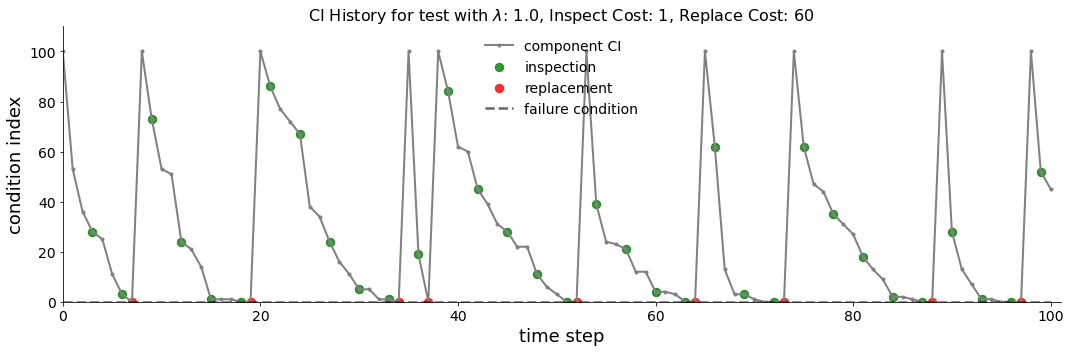

In [15]:
# testing for a single component and budget

# run a policy on the component with baseline strategy
inspect_interval = 3
replace_failure_threshold = 0.5
survive_probs = []

budget_remaining = 1000.0
num_steps = 0
last_known_state = 100
num_survive_steps = 0

i = 12
component =  Component(name='test', inspect_cost=1, replace_cost=60, dynamics_scale=36.6, dynamics_shape=1.68)
component.reset()

while budget_remaining > 0 and num_steps < 100:

    if component.current_state > 0:
        num_survive_steps += 1

    # inspection
    if num_steps % inspect_interval == 0:
        component.update(action=1)
        budget_remaining -= component.inspect_cost
        last_known_state = component.current_state
    elif component.get_failure_probability(last_known_state) >= replace_failure_threshold and budget_remaining >= component.replace_cost:
        component.update(action=2)
        budget_remaining -= component.replace_cost
        last_known_state = component.current_state
    else:
        component.update(action=0)

    num_steps += 1

component.visualize_history()